Importing library

In [63]:
import os
from astropy.io import fits
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py
from keras.preprocessing.image import ImageDataGenerator

In [60]:
import os
import tensorflow as tf
import tensorflow_probability as tfp
tfpl = tfp.layers
tf1 = tf.compat.v1
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [61]:
from tensorflow_probability.python.distributions import kl_divergence

In [62]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [64]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


Importing data

In [69]:
hf = h5py.File('/mnt/data/HSC/HSC_v6/extra_files/five_band_image127x127_full.hdf5', 'r')

In [70]:
n = 5000

In [71]:
x = hf["image"][0:n]
y = hf["specz"][0:n]

In [72]:
x = np.transpose(x,(0,2,3,1))

In [73]:
## check this
max_value = np.max(x)
max_value

1108.394

In [74]:
x_new = np.true_divide(x,max_value)

In [75]:
hf.close()

Image Augmentation

In [76]:
##datagen = ImageDataGenerator(rotation_range=90)
##it = datagen.flow(x_new, batch_size=1)

In [77]:
x_train, x_test, y_train, y_test = train_test_split(x_new,y,test_size=0.2)

In [78]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [79]:
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer=lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable=True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale= + 10e-4*tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [82]:
from sklearn.model_selection import train_test_split



model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='tanh',input_shape=(127,127,5)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size=(2,2),activation='tanh'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size=(3,3),activation='relu'))
model.add(Conv2D(32, kernel_size=(2,2),activation='relu'))
model.add(Flatten())
model.add(tfpl.DenseVariational(512, activation='tanh', make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable, kl_weight=1/n))
model.add(tfpl.DenseVariational(128, activation='tanh', make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable, kl_weight=1/n))
model.add(Dense(2))
model.add(tfpl.IndependentNormal(1))



#model.compile(optimizer='Adam', loss="mse",metrics=[tf.keras.metrics.MeanAbsoluteError()])


model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 125, 125, 32)      1472      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 61, 61, 32)        4128      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 27, 27, 32)        4128      
_________________________________________________________________
flatten_4 (Flatten)          (None, 23328)            

In [84]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

model.compile(optimizer='Adam', loss = negative_loglikelihood, metrics=[keras.metrics.RootMeanSquaredError()])

In [ ]:
model.fit(x = x_train, y = y_train, epochs = 300, shuffle = True, verbose=1)

Epoch 1/300
125/125 [==============================] - 49s 11ms/step - loss: 1.0378 - root_mean_squared_error: 0.9642
Epoch 2/300
125/125 [==============================] - 1s 11ms/step - loss: 0.8234 - root_mean_squared_error: 0.7866
Epoch 3/300
125/125 [==============================] - 1s 11ms/step - loss: 1.0993 - root_mean_squared_error: 1.0873
Epoch 4/300
125/125 [==============================] - 1s 11ms/step - loss: 0.9541 - root_mean_squared_error: 0.9304
Epoch 5/300
125/125 [==============================] - 1s 11ms/step - loss: 0.9603 - root_mean_squared_error: 1.0937
Epoch 6/300
125/125 [==============================] - 1s 11ms/step - loss: 0.6473 - root_mean_squared_error: 0.7276
Epoch 7/300
125/125 [==============================] - 1s 10ms/step - loss: -1.0232e-04 - root_mean_squared_error: 0.5671
Epoch 8/300
125/125 [==============================] - 1s 11ms/step - loss: -0.2529 - root_mean_squared_error: 0.5004
Epoch 9/300
125/125 [==============================] - 1s

125/125 [==============================] - 1s 10ms/step - loss: 0.7854 - root_mean_squared_error: 0.7591
Epoch 68/300
125/125 [==============================] - 1s 11ms/step - loss: 0.8562 - root_mean_squared_error: 0.8106
Epoch 69/300
125/125 [==============================] - 1s 10ms/step - loss: 0.8743 - root_mean_squared_error: 0.8155
Epoch 70/300
125/125 [==============================] - 1s 10ms/step - loss: 0.8349 - root_mean_squared_error: 0.7771
Epoch 71/300
125/125 [==============================] - 1s 10ms/step - loss: 0.8364 - root_mean_squared_error: 0.7842
Epoch 72/300
125/125 [==============================] - 1s 11ms/step - loss: 0.8606 - root_mean_squared_error: 0.8160
Epoch 73/300
125/125 [==============================] - 1s 10ms/step - loss: 0.8211 - root_mean_squared_error: 0.7665
Epoch 74/300
125/125 [==============================] - 1s 10ms/step - loss: 0.8447 - root_mean_squared_error: 0.7689
Epoch 75/300
125/125 [==============================] - 1s 11ms/step 

125/125 [==============================] - 1s 10ms/step - loss: 0.8806 - root_mean_squared_error: 0.8143
Epoch 137/300
125/125 [==============================] - 1s 10ms/step - loss: 0.8326 - root_mean_squared_error: 0.7741
Epoch 138/300
125/125 [==============================] - 1s 10ms/step - loss: 0.8461 - root_mean_squared_error: 0.8279
Epoch 139/300
125/125 [==============================] - 1s 10ms/step - loss: 0.8309 - root_mean_squared_error: 0.7796
Epoch 140/300
125/125 [==============================] - 1s 11ms/step - loss: 0.8423 - root_mean_squared_error: 0.7986
Epoch 141/300
125/125 [==============================] - 1s 10ms/step - loss: 0.8665 - root_mean_squared_error: 0.8052
Epoch 142/300
125/125 [==============================] - 1s 10ms/step - loss: 0.8520 - root_mean_squared_error: 0.7898
Epoch 143/300
125/125 [==============================] - 1s 10ms/step - loss: 0.8582 - root_mean_squared_error: 0.8232
Epoch 144/300
125/125 [==============================] - 1s 10

In [40]:
y_test_prediction = []

for i in range(len(y_test)):
    y_test_prediction.append(model_variational(np.array([x_test[i]])).mean()[0][0])

y_test_prediction = np.asarray(y_test_prediction)

y_test_ = []

for i in range(len(y_test)):
    y_test_.append(y_test[i][0])

y_test_ = np.asarray(y_test_)

In [41]:
from photoz_utils import *
y_test_new = pd.Series(y_test_)
y_test_predict_new = pd.Series(y_test_prediction)
get_point_metrics(y_test_predict_new,y_test_new)

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",1000,0.227971,-0.006716,-0.005315,0.097117,0.077974,0.119,0.17,0.113042


In [42]:
binned_metrics_test = get_point_metrics(y_test_predict_new,y_test_new,binned = True)
plot_point_metrics(binned_metrics_test)

KeyError: Interval(3.6, 3.8, closed='right')

In [43]:
y_train_predict = model_variational.predict(x_train)
y_train_prediction = []

for i in range(len(y_train)):
    y_train_prediction.append(y_train_predict[i][0])

y_train_prediction = np.asarray(y_train_prediction)

y_train_ = []

for i in range(len(y_train)):
    y_train_.append(y_train[i][0])

y_train_ = np.asarray(y_train_)

In [44]:
from photoz_utils import *
y_train_new = pd.Series(y_train_)
y_train_predict_new = pd.Series(y_train_prediction)
get_point_metrics(y_train_predict_new,y_train_new)

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",4000,0.061807,-0.009075,-0.008952,0.036757,0.031832,0.08075,0.00875,0.008155


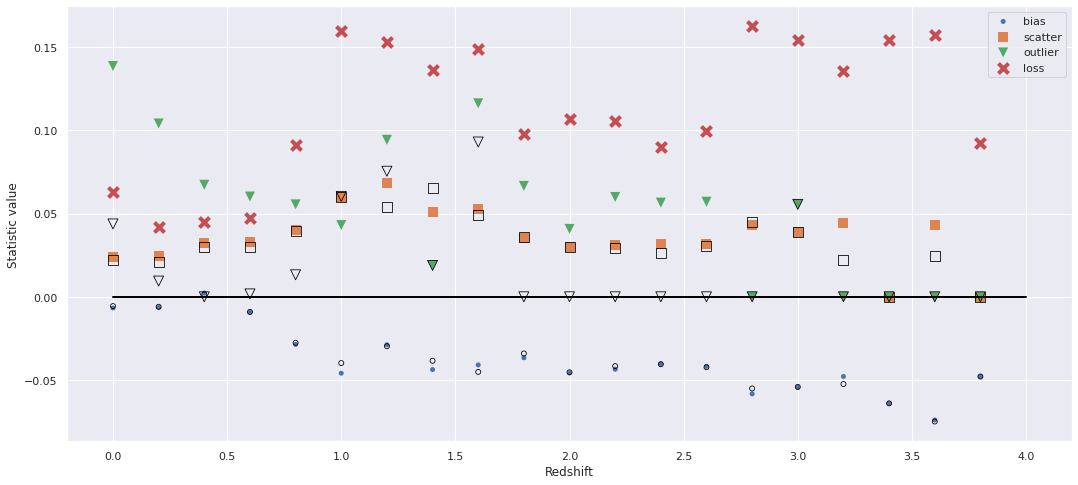

In [45]:
binned_metrics_train = get_point_metrics(y_train_predict_new,y_train_new,binned = True)
plot_point_metrics(binned_metrics_train)

In [46]:
from scipy.stats import gaussian_kde
xy = np.vstack([y_test_,y_test_prediction])
z = gaussian_kde(xy)(xy)

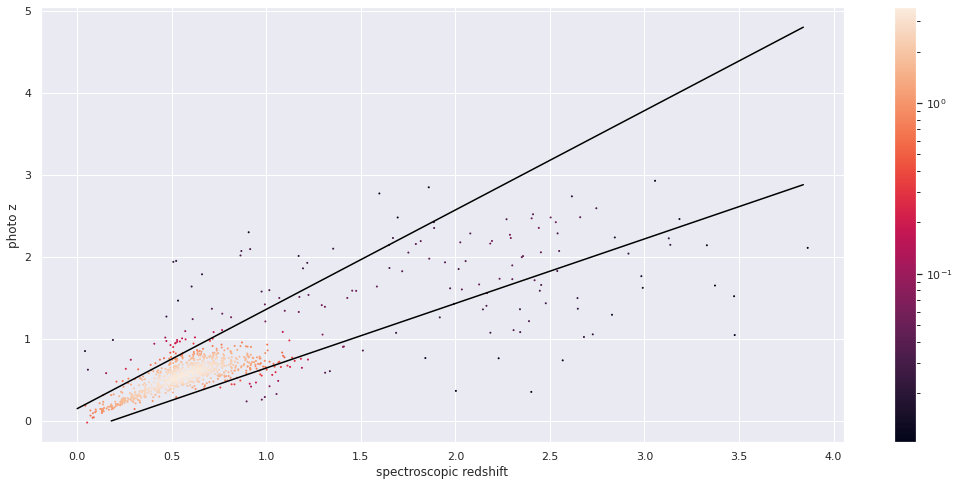

In [47]:
import matplotlib.cm as cm
import matplotlib
fig, ax = plt.subplots()
ax_ = ax.scatter(y_test, y_test_prediction, c=z,s = 1,edgecolor=None, norm=matplotlib.colors.LogNorm())
plt.colorbar(ax_)
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([.18,1.6*2.4],[0,1.2*2.4], color='black')
plt.plot([0, 1.6 * 2.4], [.15, 2 * 2.4],color = 'black')